# Coral Species Classification using Convolutional Neural Networks

## Introduction
Brief explanation of the problem: classifying coral species using deep learning.

## Step 0. Check GPU Availability and TensorFlow Version

Before training deep learning models, it's important to check whether TensorFlow can access a GPU. Training on a GPU is significantly faster than on a CPU, especially for large image image datasets.

If you've followed the setup instructions in the [GitHub README](https://github.com/kbeavers/jellyfish-species-CNN-tutorial), and you've run the `install_kernel.sh` script on **Frontera**, you should now be running this notebook inside a containerized Jupyter kernel that includes:
- TensorFlow with GPU support
- CUDA libraries compatible with the system
- All required Python packages pre-installed

This cell will confirm that your environment is correctly configured (TIP: Make sure you change your kernel to `tf-cuda101`.) 

In [177]:
import tensorflow as tf

# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Print TensorFlow version (should be ____)
print(tf.__version__)

Num GPUs Available:  0
2.18.0


## Step 1. Data Loading and Organization

In this step, we load all coral images from the dataset directory and organize them into a `DataFrame`. Each image is assigned a label based on the name of the folder it's stored in (i.e., 'ACER', 'CNAT', 'MCAV').

This `DataFrame` will serve as the foundation for splitting our data into training, validation, and test sets later. 

### 1.1. List Dataset Directory Contents
Before loading the images, we first want to inspect the directory to make sure everything is in the right place. The code below lists the contents of the root directory to verify that the folders for each species (i.e. 'MCAV', 'ACER', 'CNAT') are present and correctly named.

In [178]:
from pathlib import Path

# Set up your data root
data_root = Path('../data/coral-species')

# List the contents of the directory
print(list(data_root.iterdir()))

# You should see something like this:
# [PosixPath('../data/coral-species/MCAV'), PosixPath('../data/coral-species/ACER'), PosixPath('../data/coral-species/CNAT')]

[PosixPath('../data/coral-species/MCAV'), PosixPath('../data/coral-species/ACER'), PosixPath('../data/coral-species/CNAT')]


### 1.2. Check File Extensions
Next, we scan the dataset directory and all its sub-directories to find out what types of image files are present. This helps catch unexpected or unsupported file types (e.g., '.gif', '.txt'), which could cause problems later when loading images. 

We expect most or all files to be standard image formats like '.jpg' or '.png'.

In [186]:
# Recursively list all files under the dataset directory
image_files = list(data_root.rglob("*"))

# Extract and print the unique file extensions (e.g., .jpg, .png)
# This helps us confirm that only valid image files are present
extensions = set(p.suffix.lower() for p in image_files if p.is_file())
print("File extensions found:", extensions)

File extensions found: {'.jpg'}


### 1.3. Explore Image Dimensions and Color Modes
Before feeding images into a CNN, it's important to understand the basic properties of the dataset. In this step, we examine the **dimensions** (width x height), as well as the **color mode** (e.g., RGB, RGBA, grayscale) of each image. This helps us decide if we need to resize or convert images before we begin training our CNN. 

The script below prints a summary and gives recommendations if inconsistencies are found.

In [187]:
from PIL import Image
from pathlib import Path
from collections import Counter

def explore_image_dataset(data_root):
    """
    Explore basic properties of images: size and color mode.
    """
    print("Starting image dataset exploration...\n")
    
    # Gather all .jpg files in the dataset
    image_files = list(Path(data_root).rglob('*.jpg'))
    print(f"Found {len(image_files)} image files\n")
    
    # Track sizes and color modes
    image_sizes = []
    color_modes = []

    print("Checking image dimensions and color modes...\n")
    for img_path in image_files:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)   
            color_modes.append(img.mode)  

    # Summarize image sizes
    size_counts = Counter(image_sizes)
    print("=== Image Sizes ===")
    print(f"Found {len(size_counts)} unique image sizes:")
    for size, count in size_counts.most_common():
        print(f"- {size}: {count} images")

    # Summarize color modes
    mode_counts = Counter(color_modes)
    print("\n=== Color Modes ===")
    print(f"Found {len(mode_counts)} unique color modes:")
    for mode, count in mode_counts.most_common():
        print(f"- {mode}: {count} images")

    # Simple recommendations
    print("\n=== Recommendations ===")
    if len(size_counts) > 1:
        print(f"Images have different sizes. Consider resizing.")
    else:
        print("All images are the same size.")
    
    if len(mode_counts) > 1:
        print("Images have different color modes. Consider converting to RGB.")
    else:
        print("All images share the same color mode.")

# Run the function
data_root = Path('../data/coral-species')
explore_image_dataset(data_root)

Starting image dataset exploration...

Found 500 image files

Checking image dimensions and color modes...

=== Image Sizes ===
Found 132 unique image sizes:
- (2048, 1536): 200 images
- (1536, 2048): 50 images
- (2048, 1365): 40 images
- (960, 720): 18 images
- (1800, 1350): 16 images
- (2048, 1368): 11 images
- (2048, 1792): 7 images
- (1365, 2048): 5 images
- (720, 960): 5 images
- (1792, 2048): 5 images
- (2048, 1152): 4 images
- (2048, 1638): 3 images
- (2048, 1366): 3 images
- (1280, 720): 3 images
- (1368, 2048): 3 images
- (2048, 1542): 3 images
- (1068, 1600): 2 images
- (1000, 750): 2 images
- (1600, 1200): 2 images
- (1750, 1313): 2 images
- (2048, 1457): 2 images
- (1280, 959): 2 images
- (2048, 1155): 2 images
- (720, 540): 2 images
- (2048, 1848): 1 images
- (1152, 864): 1 images
- (1673, 1115): 1 images
- (2047, 1818): 1 images
- (2048, 1707): 1 images
- (1350, 1800): 1 images
- (2048, 1859): 1 images
- (1956, 2048): 1 images
- (2048, 1713): 1 images
- (388, 541): 1 imag

### 1.4 Check for Corrupted Images

Before continuing, we want to make sure that all image files are readable, Corrupted files can break your model training or cause unexpected errors during preprocessing.

In this step, we:
1. Attempt to open each '.jpg' file using PIL
2. Discard any files that fail to load

This ensures we only keep clean, valid images for training.

In [188]:
from PIL import Image
from tqdm import tqdm

# Find all .jpg files
image_paths = list(data_root.rglob("*.jpg"))

# Check for corrupted files
valid_paths = []
bad_files = []

print("Checking for corrupted images...\n")
for path in tqdm(image_paths):
    try:
        # Try to open and verify the image
        with Image.open(path) as img:
            img.verify()
        valid_paths.append(path)
    except Exception:
        bad_files.append(path)

print(f"Valid images: {len(valid_paths)}")
print(f"Corrupted images removed: {len(bad_files)}")


Checking for corrupted images...



100%|██████████| 500/500 [00:00<00:00, 13273.20it/s]

Valid images: 500
Corrupted images removed: 0


### 1.5. Create a DataFrame of Image Paths and Labels
In this step, we build a `pandas.DataFrame` that organizes all the image data into two columns:
 - filepath: the full path to each image file
 - label: the class label, inferred from the folder name

This structured DataFrame is essential for training with Keras' `flow_from_dataframe()` method.

In [189]:
import pandas as pd

# Build (filepath, label) pairs from valid image paths
data = []
for path in valid_paths:
    label = path.parent.name  # Use folder name as class label
    data.append((str(path), label))

# Create a DataFrame with columns for file path and label
df = pd.DataFrame(data, columns=["filepath", "label"])

# Shuffle the DataFrame (with a fixed seed for reproducibility)
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

# Show a preview of the dataset
df.head()

filepath label
0      ../data/coral-species/ACER/acropora_058.jpg  ACER
1      ../data/coral-species/ACER/acropora_179.jpg  ACER
2      ../data/coral-species/ACER/acropora_187.jpg  ACER
3  ../data/coral-species/CNAT/colpophyllia_135.jpg  CNAT
4      ../data/coral-species/ACER/acropora_156.jpg  ACER

## Step 2. Visualize the Class Distribution

Before training our model, it's important to understand how many images we have for each class (species).

In this step, we:
- Count how many images belong to each class
- Plot the distribution using a bar chart and pie chart

If the dataset is imbalanced (i.e., some classes have far more images than others), we may need to account for this later using class weights or data augmentation.

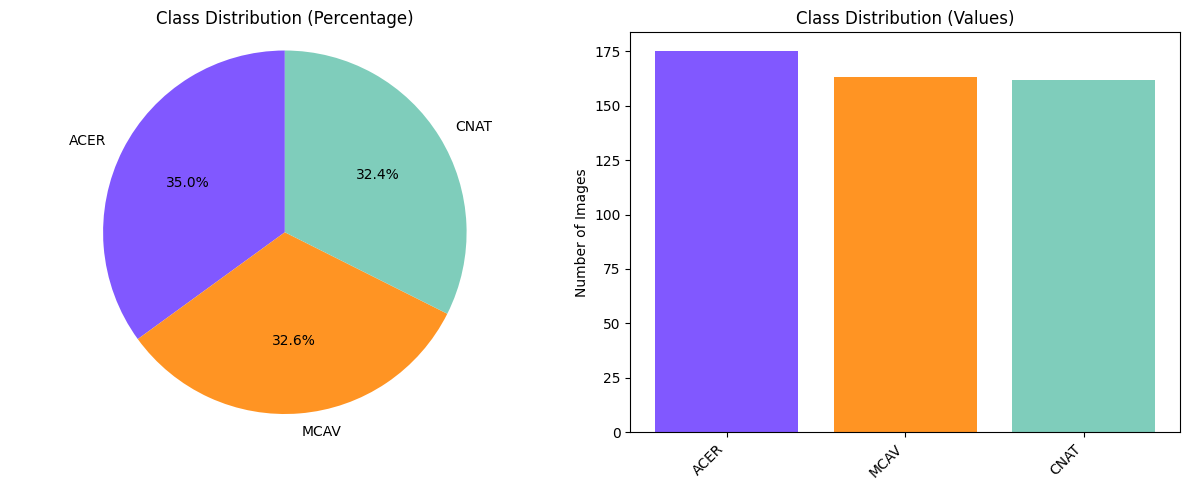

ACER: 175 images (35.000000%)
MCAV: 163 images (32.600000%)
CNAT: 162 images (32.400000%)


In [190]:
import matplotlib.pyplot as plt

# Count class distribution
counts = df['label'].value_counts()

# Create a 1-row, 2-column subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define a color palette for consistency
colors = ['#8158ff', '#ff9423', '#7fcdbb'] 

# Pie chart
axes[0].pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].axis('equal')
axes[0].set_title('Class Distribution (Percentage)')

# Bar chart
axes[1].bar(counts.index, counts.values, color=colors)
axes[1].set_title('Class Distribution (Values)')
axes[1].set_ylabel('Number of Images')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

# Layout adjustment
plt.tight_layout()
plt.show()

# Print label counts and percentages
for label, count in counts.items():
    print(f"{label}: {count} images ({count/len(df)*100:1f}%)")

Our dataset contains three coral species: ACER (*Acropora cervicornis*), MCAV (*Montastraea cavernosa*), and CNAT (*Colpophyllia natans*). The class distribution is well balanced, with the largest class (ACER) making up ~35% of the dataset and the smallest class (CNAT) making up ~32% of the dataset. 

Because all three classes are similarly represented, we do not need to apply class weighting or balancing techniques during training. 

## Step 3. Visualizing Images from the Dataset
It's helpful to look at a few images from each class. This will give us a better sense of:
- What each coral species looks like
- How much visual variation exists within each class
- Whether the dataset includes noise, blur, or other artifacts

We'll display a grid of randomly selected images, grouped by class.

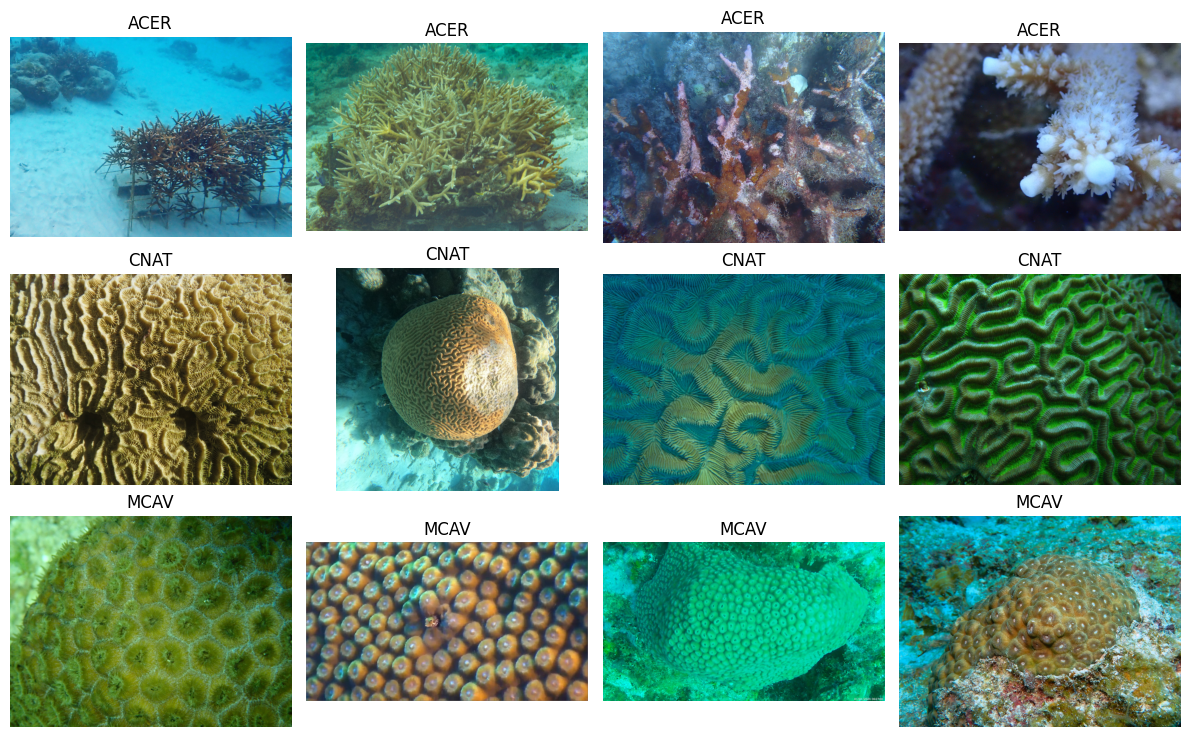

In [191]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random

# Set seed for reproducibility
random.seed(123)

# How many samples to show per class
samples_per_class = 4
classes = df['label'].unique()

plt.figure(figsize=(12, len(classes) * 2.5))

# Loop through each class
for i, label in enumerate(sorted(classes)):
    # Get filepaths for this class only
    class_df = df[df['label'] == label]
    sample_paths = random.sample(list(class_df['filepath']), samples_per_class)
    
    # Plot images for this class
    for j, img_path in enumerate(sample_paths):
        plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
        img = load_img(img_path)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()

## Step 4: Split the Dataset and Handle Class Imbalance

### 4.1. Split the Dataset into Training, Validation and Test Sets
We divide our labeled image dataset into three parts:

 - **Training Set**: Used to train the model
 - **Validation Set**: Used to tune hyperparameters and monitor overfitting
 - **Test Set**: Used only for final evaluation

We use `train_test_split()` from scikit-learn in two stages:

 1. First, we split the original dataset into **training + test** sets
 2. Then, we split the training set again into **training + validation**.

This ensures that our CNN *never* sees the test set during training and hyperparameter tuning.

To preserve the class distribution across all splits, we use `stratify=df["label"]` to ensure each subset reflects the original proportions of each class. This is called **stratified sampling**.

#### Thought Challenge

> **Will changing the `random_state` in `train_test_split()` change your model's learned parameters? Why or why not?**

**Answer**: Yes — even though stratification preserves class balance, changing `random_state` changes *which individual images* go into the training set. For example:
 - With `random_state=123`, the model might learn from images A, B, and C
 - With `random_state=456`, the model might learn from images D, E, and F

Since each image has unique properties (lighting, orientation, background), the model will learn slightly different features depending on the exact training set. As a result, its internal weights and final accuracy may vary.

Try running the full training pipeline multiple times with different `random_state` values. Do your metrics stay stable? What might that tell you about the robustness of your model?

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# First split with stratification
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],  # This ensures each split maintains class proportions
    random_state=123)

# Second split with stratification
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["label"],  # This maintains proportions in train/val split
    random_state=123)

# Print split sizes
total = len(df)
print(f"\nDataset splits:")
print(f"Train: {len(train_df)} images ({len(train_df)/total:.2%})")
print(f"Validation: {len(val_df)} images ({len(val_df)/total:.2%})")
print(f"Test: {len(test_df)} images ({len(test_df)/total:.2%})")


Dataset splits:
Train: 320 images (64.00%)
Validation: 80 images (16.00%)
Test: 100 images (20.00%)


### Step 4.2: Compute Class Weights

If our dataset is imbalanced (i.e., some classes have many more images than others), the model may learn to favor those majority classes.

To address this, we compute **class weights** based on the training data using `sklearn.utils.class_weight.compute_class_weight`. These weights:

- Assign higher importance to underrepresented classes
- Are passed into `model.fit()` using the `class_weight` argument
- Adjust how the loss is calculated during training (not the data itself)

This technique helps the model give balanced attention to all classes during learning.

In [195]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
class_labels = np.unique(train_df['label'])

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['label']
)

# Convert to a dictionary: {label: weight}
class_weight_dict = dict(zip(class_labels, class_weights))

# Preview the result
print("Computed class weights:")
for label, weight in class_weight_dict.items():
    print(f"{label}: {weight:.2f}")

Computed class weights:
ACER: 0.95
CNAT: 1.03
MCAV: 1.03


## Step 5: Image Preprocessing and Data Generators
### Step 5.1: Define Image Preprocessing and Augmentation

Before training, we need to prepare our images for input into the neural network. Keras provides the `ImageDataGenerator` class to:

- **Resize** all images to a consistent size
- **Normalize** pixel values (e.g., from [0–255] to [0–1])
- **Augment** training images to improve generalization

We define three separate data generators:

- `train_datagen`: applies both normalization and augmentation
- `val_datagen` and `test_datagen`: apply only normalization (no augmentation)

We resize all images to `(224, 224)` pixels and scale pixel values to the range [0, 1]. Augmentation techniques applied to training images include random rotation, zoom, shifts, and flips.


In [197]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define the image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=30,          # Augment: random rotation
    width_shift_range=0.2,      # Augment: horizontal shift
    height_shift_range=0.2,     # Augment: vertical shift
    zoom_range=0.2,             # Augment: random zoom
    horizontal_flip=True,       # Augment: random horizontal flip
    fill_mode='nearest'         # Fill in missing pixels after transform
)

# Validation and test generators do NOT use augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Step 5.2: Load Images Using `flow_from_dataframe()`

Now that our preprocessing pipelines are defined, we use `flow_from_dataframe()` to load images in batches directly from our labeled DataFrames (`train_df`, `val_df`, and `test_df`).

This approach is efficient and flexible — it loads only a few images at a time and allows us to:
- Resize each image to `(224, 224)`
- Shuffle training data for randomness
- Keep validation and test order fixed (for consistent evaluation)
- Return one-hot encoded class labels using `class_mode='categorical'`

We create three generators:
- `train_generator` — used for training
- `val_generator` — used to validate during training
- `test_generator` — used for final evaluation

All generators return batches of preprocessed image tensors and their labels.

In [198]:
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    color_mode='rgb',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 320 validated image filenames belonging to 3 classes.
Found 80 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


### Sanity Check: Inspect a Batch from the Training Generator

Before training the model, it's a good idea to inspect the output of the `train_generator` to make sure everything looks correct.

In this step, we:
- Retrieve one batch of images and labels
- Check the shape of the batch
- Display a few image-label pairs to confirm the generator is working

In [199]:
# Get one batch of data from the training generator
images, labels = next(train_generator)

# Check the shape of the batch
print("Image batch shape:", images.shape)     # Should be (BATCH_SIZE, 224, 224, 3)
print("Label batch shape:", labels.shape)     # Should be (BATCH_SIZE, num_classes)

# Preview the first 5 label vectors
print("\nFirst 5 labels (one-hot encoded):")
print(labels[:5])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)

First 5 labels (one-hot encoded):
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Visualize a Few Images from the Training Generator

To make sure everything is working as expected, let's display a few images from the training generator along with their decoded class labels.

This helps us verify:
- Images are loading and preprocessing correctly
- Labels match the images
- Class names are mapped correctly from one-hot encoded vectors

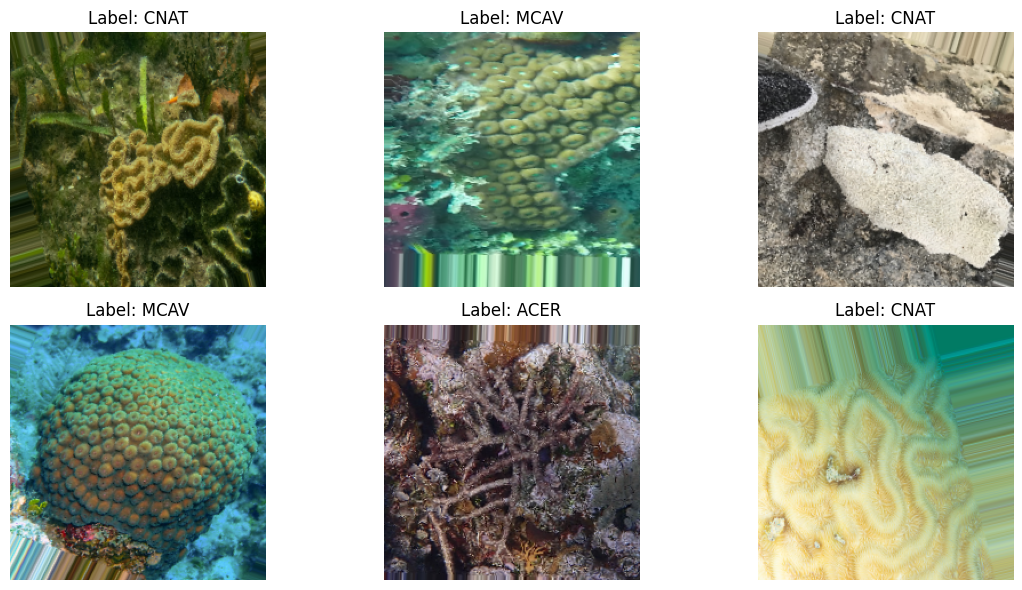

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Grab class indices from the generator and invert the dictionary
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Display 6 images and their labels
num_images = 6
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(2, 3, i + 1)
    img = images[i]
    label_index = np.argmax(labels[i])  # Decode one-hot label
    class_name = index_to_class[label_index]
    
    plt.imshow(img)
    plt.title(f"Label: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Step 6. Define Your CNN Architecture

Now that our data is ready, we can define a Convolutional Neural Network (CNN) to classify the images of different coral species.

Below, we will build a model that consists of three main parts:

1. **Convolutional Blocks** (Feature Extraction):
   - Block 1: 32 filters (3×3), followed by AveragePooling
   - Block 2: 64 filters (3×3), followed by AveragePooling
   - Block 3: 128 filters (3×3), followed by AveragePooling

   Each block increases the number of filters, allowing the network to detect more complex patterns.

2. **Flatten Layer**:
   - Converts the 3D feature maps to a 1D vector for the dense layers

3. **Dense Layers** (Classification):
   - First dense layer: 128 perceptrons
   - Second dense layer: 64 perceptrons
   - Output layer: 3 perceptrons (one for each coral species)

In [202]:
from tensorflow.keras import models, layers, optimizers

# Build a custom CNN architecture
cnn_model = models.Sequential([
    # Input layer: matches image shape
    layers.Input(shape=(224, 224, 3)),

    # Convolution Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Flatten to convert 2D feature maps into a 1D vector
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer: 3 units for 3 classes + softmax for probabilities
    layers.Dense(3, activation='softmax')
])

# Compile the model with RMSprop and a low learning rate
cnn_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture and parameter count
cnn_model.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 28, 28, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,883 (49.39 MB)

 Trainable params: 12,946,883 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

**Thought Challenge**: Break down the model summary layer by layer.

1. **First Convolutional Block**:
  - Input: 224 x 224 RGB images
  - `conv2d`: Creates 32 feature maps using 3x3 filters -> Output shape maintains input size due to padding (224, 224, 32)
  - `average_pooling_2d`: Reduces size by half -> Output shape (112, 112, 32)

2. **Second Convolutional Block**:
  - `conv2d_1`: Creates 64 feature maps using 3x3 filters -> Output shape maintains input size due to padding (112, 112, 64)
  - `average_pooling_2d_1`: Reduces size by half -> Output shape (56, 56, 64)

3. **Third Convolutional Block**:
  - `conv2d_2`: Creates 128 feature maps using 3x3 filters -> Output shape maintains input size due to padding (56, 56, 128)
  - `average_pooling_2d_2`: Halves dimensions -> Output (28, 28, 128)

4. **Classification Layers**:
  - `flatten`: Converts 3D data to 1D -> Output shape (100352)
  - `dense`: First dense layer contains 128 perceptrons
  - `dense_1`: Second dense layer contains 64 perceptrons
  - `dense_2`: Final output of 3 perceptrons (one for each coral species class)

### Calculating Paramters in CNNs

Let's break down the parameter calculation for our model:

#### Convolutional Layers
Formula: `(kernel_height x kernel_width x input_channels x filters)+ filters`
 - The `+ filters` part is for the bias term (one per filter)

1. First Conv2D: 
 - 3x3 kernel, 3 input channels (RGB), 32 filters
 - (3 x 3 x 3 x 32) + 32 = 896 parameters

2. Second Conv2D:
 - 3x3 kernel, 32 input channels, 64 filters
 - (3 x 3 x 3 x 64) + 64 = 18,496 parameters

3. Third Conv2D:
 - 3x3 kernel, 64 input channels, 128 filters
 - (3 x 3 x 64 x 128) + 128 = 73,859 parameters

#### Dense Layers
Formula: `(inputs x perceptrons) + perceptrons`
 - The `+ perceptrons` part is for the bias term (one per perceptron)

1. First Dense Layer:
 - 100352 inputs (flattened), 128 perceptrons
 - (100,352 x 128) + 128 = 12,845,184 parameters

2. Second Dense Lyaer:
 - 128 inputs, 64 perceptrons
 - (128 x 64) + 64 = 8,256 parameters

3. Output Dense Layer:
 - 64 inputs, 3 perceptrons (coral species)
 - (64 x 3) + 3 = 195 parameters

## Step 7: Train the CNN Model

Now that our CNN architecture is defined, we can train it using the `fit()` method.

During training:
- The model learns patterns in the **training set**
- Its performance is evaluated on the **validation set** after each epoch
- We pass in `class_weight` to help balance the influence of each class during loss calculation (based on Step 4.2)

We also track the training history, which we’ll use later to visualize performance over time.

In [203]:
# Train the CNN model
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict  # Computed earlier to handle class imbalance
)

/Users/kbeavers/Documents/GitHub/life_sciences_ml_at_tacc/.conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2753 - loss: 1.1109 - val_accuracy: 0.3500 - val_loss: 1.0963
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 945ms/step - accuracy: 0.3981 - loss: 1.0835 - val_accuracy: 0.3500 - val_loss: 1.1023
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3695 - loss: 1.0808 - val_accuracy: 0.3500 - val_loss: 1.0929
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 953ms/step - accuracy: 0.4380 - loss: 1.0564 - val_accuracy: 0.3875 - val_loss: 1.0960
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 946ms/step - accuracy: 0.4660 - loss: 1.0277 - val_accuracy: 0.3500 - val_loss: 1.0909
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 995ms/step - accuracy: 0.4264 - loss: 1.0440 - val_accuracy: 0.3500 - val_loss: 1.0931
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 961ms/step - accuracy: 0.4816 - loss: 0.9993 - val_accuracy: 0.3750 - val_loss: 1.0968
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 926ms/step - accuracy: 0.5263 - loss: 1.0030 - val_accuracy: 0

## Step 8: Visualize Training and Validation Accuracy/Loss

After training the model, we can visualize the accuracy and loss over time to better understand how the model is learning.

These plots can help us diagnose:
- Underfitting (both accuracies low)
- Overfitting (training accuracy rises while validation accuracy drops)
- Healthy learning (both rise and stabilize)

We use the `cnn_history` object returned by `model.fit()` to plot:
- Training vs. validation accuracy
- Training vs. validation loss

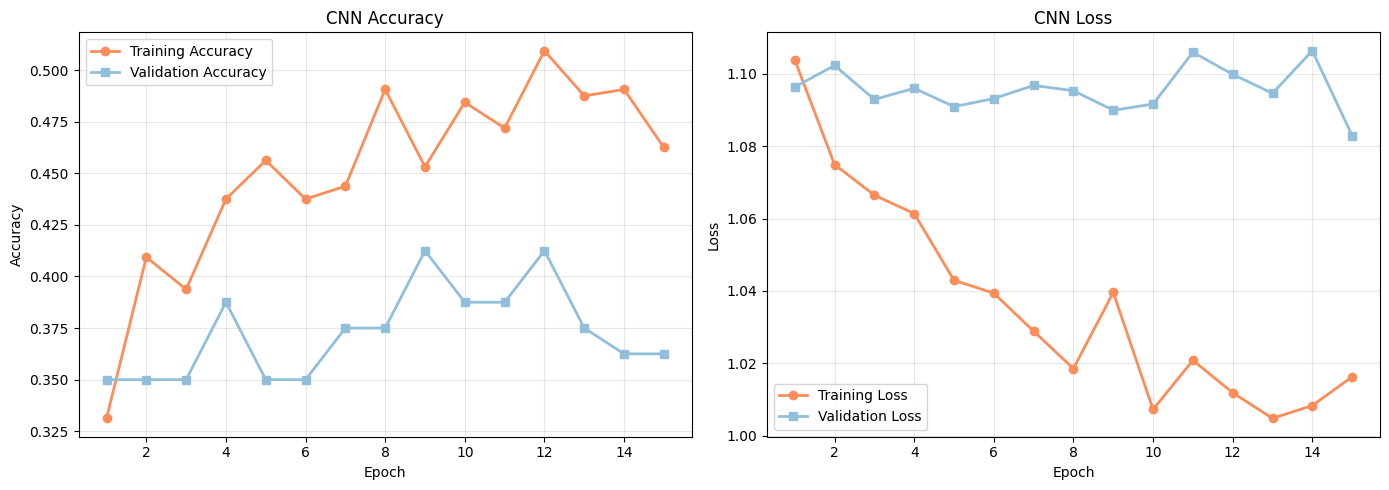

In [227]:
import matplotlib.pyplot as plt

def plot_training_history(history, title_prefix="CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Set color palette
    training_color = '#fc8d59'    
    validation_color = '#91bfdb'  

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color=training_color, linestyle='-', marker='o',
             label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, color=validation_color, linestyle='-', marker='s',
             label='Validation Accuracy', linewidth=2)
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color=training_color, linestyle='-', marker='o',
             label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, color=validation_color, linestyle='-', marker='s',
             label='Validation Loss', linewidth=2)
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(cnn_history)

The plots above show the training and validation accuracy/loss over 15 epochs. 

**Accuracy (Left Plot)**
- Training accuracy increases over time, reaching about 50% before declining in the final epochs
- Validation accuracy remains low, indicating poor generalization. 
- The growing gap between training and validation accuracy suggests **overfitting**

**Loss (Right Plot)**
- Training loss steadily decreases, showing that the model is fitting the training data
- Validation loss fluctuates and does not improve, further confirming overfitting.

**Interpretation: The model is memorizing the training data but failing to learn patterns that generalize to unseen data.** This is a common challenge when training a CNN from scratch. 

## Step 9: Evaluate the Model on Test Data

After training and validating the model, we evaluate its performance on the **test set** — data the model has never seen before.

This helps us answer the question: *How well will the model perform on real-world, unseen data?*

We use:
- `model.evaluate()` to get the test accuracy and loss
- `model.predict()` to get predicted probabilities
- `confusion_matrix()` from `sklearn` to compare predictions with ground truth labels

We’ll also display the confusion matrix as a heatmap for easier interpretation.

/Users/kbeavers/Documents/GitHub/life_sciences_ml_at_tacc/.conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 41.00%
Test Loss: 1.0813
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step


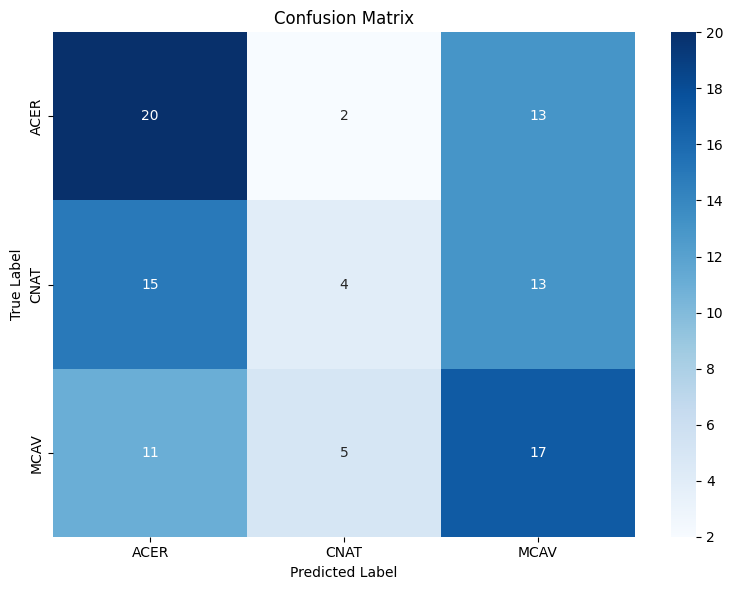

In [205]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Evaluate test accuracy and loss
test_loss, test_acc = cnn_model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Get predicted probabilities for each class
pred_probs = cnn_model.predict(test_generator)

# Convert to predicted class labels
y_pred = np.argmax(pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Map class indices back to names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Step 10: Classification Report and Prediction Summary

To better understand model performance across each class, we generate a **classification report** and a **prediction summary table**.

The classification report includes:
- **Precision**: How many predicted labels were correct
- **Recall**: How many actual labels were correctly predicted
- **F1-score**: Harmonic mean of precision and recall
- **Support**: Number of true samples per class

### Classification Report

In [207]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        ACER       0.43      0.57      0.49        35
        CNAT       0.36      0.12      0.19        32
        MCAV       0.40      0.52      0.45        33

    accuracy                           0.41       100
   macro avg       0.40      0.40      0.38       100
weighted avg       0.40      0.41      0.38       100



# Section 2: Transfer Learning with VGG19

In this section, we apply a technique called **transfer learning** to improve model performance on our coral classification task.

**Transfer learning** is a deep learning technique where we *reuse a model that has already been trained on a large dataset* (like ImageNet) for a different but related task. Instead of starting from scratch, we "transfer" the learned knowledge — typically early layers that extract general features like edges, textures, and shapes — to our new task.

This is especially useful when:
- You have **limited labeled data**
- You want to train a model **faster**
- You want to achieve **better accuracy** with less computational effort

We use the **VGG19 architecture**, a classic convolutional neural network developed by researchers at Oxford. It was trained on **ImageNet**, a dataset with over **14 million images and 1,000 classes**.

VGG19 is a strong choice because:
- It has a **simple and well-understood architecture**
- Its early layers extract **generic features** that work well across many types of images
- It is widely used in computer vision tasks and compatible with Keras

This process allows us to take advantage of what VGG19 already knows — and specialize it for classifying coral species like *ACER*, *MCAV*, and *CNAT*.

## Step 1: Prepare Data for VGG19

VGG19 expects input images to be preprocessed in a very specific way — using the `preprocess_input` function from `tensorflow.keras.applications.vgg19`. This function:

- Converts RGB pixel values to the format VGG19 was originally trained on (e.g., channels in BGR order, zero-centered with respect to ImageNet)
- Ensures compatibility with the pretrained weights

We’ll now create new data generators for VGG19 using `ImageDataGenerator` with:
- `preprocess_input` for normalization
- Augmentation on the training set
- No augmentation on validation/test sets

In [211]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define new ImageDataGenerators for VGG19
vgg19_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

vgg19_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
vgg19_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


## Step 2: Load Images Using `flow_from_dataframe()` (VGG19-Compatible)

We now load our images from the `train_df`, `val_df`, and `test_df` DataFrames using `flow_from_dataframe()`.

This method:
- Reads images from disk in batches
- Applies the preprocessing steps defined in our VGG19-compatible `ImageDataGenerator`
- Resizes images to `(224, 224)`
- Converts labels to **one-hot encoded vectors** with `class_mode='categorical'`

This setup ensures that images are processed the same way VGG19 expects — and allows efficient streaming of batches during training and evaluation.

In [212]:
# Assuming you have train_df, val_df, test_df already split

train_generator_vgg19 = vgg19_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

val_generator_vgg19 = vgg19_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_vgg19 = vgg19_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 320 validated image filenames belonging to 3 classes.
Found 80 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


## Step 3: Load VGG19 Base and Add a Custom Classifier (with Callbacks)

We now load the **VGG19 base model**, which has been pre-trained on ImageNet. We exclude the original classification head (`include_top=False`) and freeze all convolutional layers for now.

Next, we stack a **custom classifier** on top using Keras’ `Sequential` API:
- Flatten the output of VGG19’s last convolutional layer
- Add two fully connected layers with `ReLU`, `BatchNormalization`, and `Dropout`
- End with a softmax layer for 3-class classification

We also add a few **training callbacks** to make the process more robust:
- `EarlyStopping`: stops training if validation accuracy stops improving
- `ReduceLROnPlateau`: lowers the learning rate if validation loss plateaus

In [213]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load VGG19 base (without top classifier)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # Freeze all pretrained layers

# Build the full model
VGG19_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Output layer for 3-class classification
])

# Compile with a low learning rate optimizer
VGG19_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model with callbacks
VGG19_history = VGG19_model.fit(
    train_generator_vgg19,
    validation_data=val_generator_vgg19,
    epochs=15,
    callbacks=callbacks
)

/Users/kbeavers/Documents/GitHub/life_sciences_ml_at_tacc/.conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.4822 - loss: 1.3990 - val_accuracy: 0.5875 - val_loss: 1.8005 - learning_rate: 1.0000e-04
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.6808 - loss: 0.7937 - val_accuracy: 0.7625 - val_loss: 1.0433 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7592 - loss: 0.5956 - val_accuracy: 0.8375 - val_loss: 0.6696 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8314 - loss: 0.4518 - val_accuracy: 0.8125 - val_loss: 0.6067 - learning_rate: 1.0000e-04
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.7916 - loss: 0.4622 - val_accuracy: 0.8125 - val_loss: 0.5219 - learning_rate: 1.0000e-04
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8404 - loss: 0.4302 - val_accuracy: 0.8250 - val_loss: 0.4958 - learning_rate: 1.0000e-04
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8190 - loss:

## Step 4: Plot Training and Validation Accuracy/Loss (VGG19)

Now that we've trained the VGG19-based model, let's visualize the training and validation performance over time.

This helps us:
- Compare transfer learning to the earlier scratch-trained CNN
- Check for signs of underfitting or overfitting
- Identify whether early stopping was triggered

We’ll plot:
- Accuracy: training vs. validation
- Loss: training vs. validation

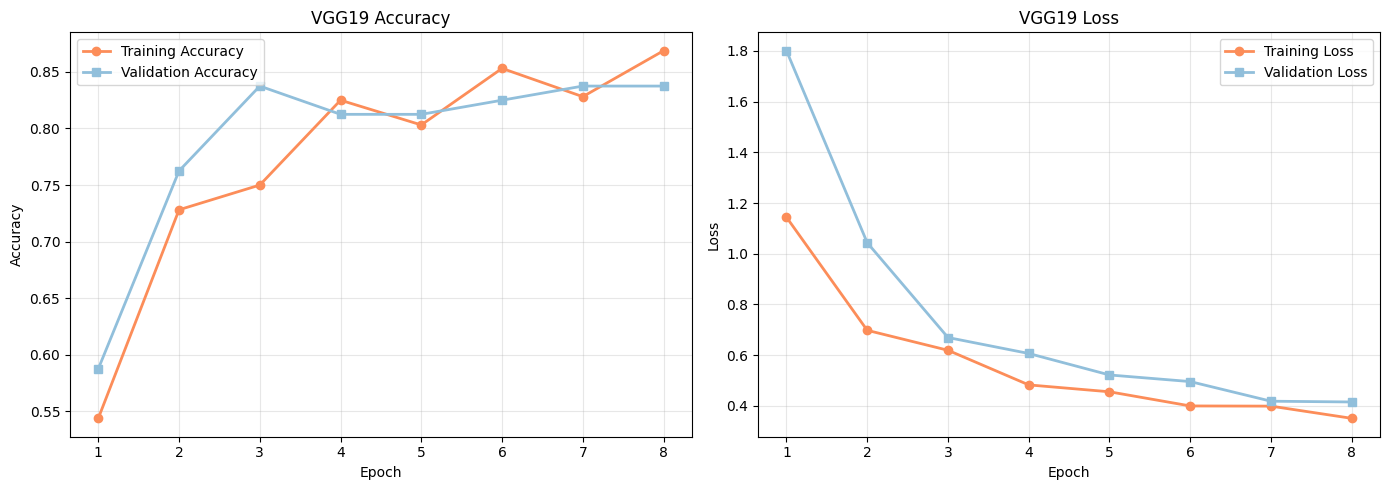

In [225]:
import matplotlib.pyplot as plt

def plot_training_history(history, title_prefix="VGG19"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Colorblind-friendly colors
    training_color = '#fc8d59'    
    validation_color = '#91bfdb'   
    
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color=training_color, linestyle='-', marker='o', 
             label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, color=validation_color, linestyle='-', marker='s', 
             label='Validation Accuracy', linewidth=2)
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color=training_color, linestyle='-', marker='o', 
             label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, color=validation_color, linestyle='-', marker='s', 
             label='Validation Loss', linewidth=2)
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot for VGG19
plot_training_history(VGG19_history, title_prefix="VGG19")

## Step 5: Evaluate the VGG19 Model on the Test Set

After training the VGG19-based model, we evaluate its performance on the **unseen test set**.

This step helps us measure how well the model generalizes to new data. We'll:
- Compute test accuracy and loss using `model.evaluate()`
- Generate predicted class labels using `model.predict()`
- Create and display a confusion matrix to compare predictions with ground truth labels

/Users/kbeavers/Documents/GitHub/life_sciences_ml_at_tacc/.conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 83.00%
Test Loss: 0.5127
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


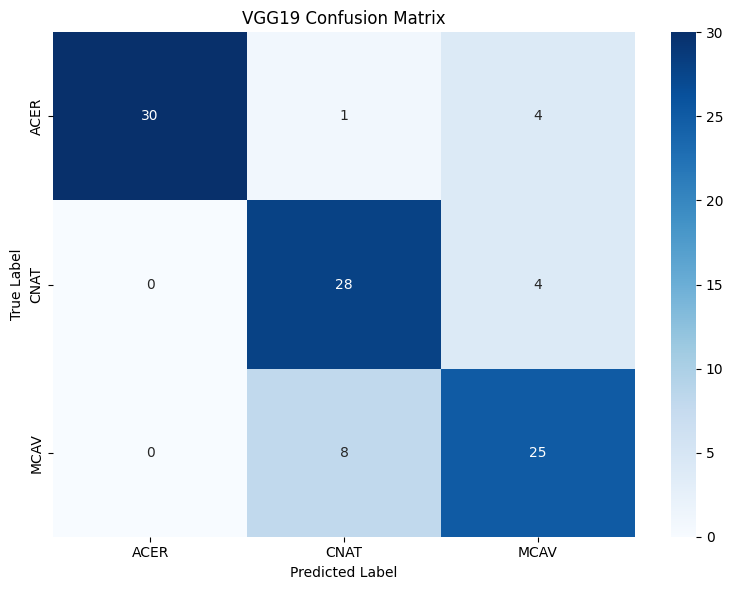

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Evaluate on the test set
test_loss, test_acc = VGG19_model.evaluate(test_generator_vgg19, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
vgg19_pred_probs = VGG19_model.predict(test_generator_vgg19)
vgg19_y_pred = np.argmax(vgg19_pred_probs, axis=1)
vgg19_y_true = test_generator_vgg19.classes

# Confusion matrix
cm = confusion_matrix(vgg19_y_true, vgg19_y_pred)
class_names = list(test_generator_vgg19.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("VGG19 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Step 6: Classification Report and Prediction Summary

To better understand how the VGG19 model performs on each class, we generate:
- A **classification report** showing precision, recall, F1-score, and support
- A **prediction summary table** that includes:
  - Filepath of each test image
  - True label
  - Predicted label
  - Model's confidence in its prediction

### Classification Report

In [216]:
from sklearn.metrics import classification_report

# Convert class indices to readable labels
print("Classification Report (VGG19):")
print(classification_report(vgg19_y_true, vgg19_y_pred, target_names=class_names))

Classification Report (VGG19):
              precision    recall  f1-score   support

        ACER       1.00      0.86      0.92        35
        CNAT       0.76      0.88      0.81        32
        MCAV       0.76      0.76      0.76        33

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



### Prediction DataFrame with Confidence Scores

In [217]:
import pandas as pd

# Map indices to class names
vgg19_pred_class_names = [class_names[i] for i in vgg19_y_pred]
vgg19_true_class_names = [class_names[i] for i in vgg19_y_true]

# Get the confidence score of the predicted class
vgg19_confidences = vgg19_pred_probs[np.arange(len(vgg19_pred_probs)), vgg19_y_pred]

# Create summary DataFrame
vgg19_results_df = pd.DataFrame({
    'Filepath': test_generator_vgg19.filepaths,
    'True Label': vgg19_true_class_names,
    'Predicted Label': vgg19_pred_class_names,
    'Confidence': vgg19_confidences
})

# Show top 10 most confident predictions
vgg19_results_df.sort_values(by='Confidence', ascending=False).head(10)

Filepath True Label  \
30  ../data/coral-species/CNAT/colpophyllia_072.jpg       CNAT   
29  ../data/coral-species/CNAT/colpophyllia_048.jpg       CNAT   
90  ../data/coral-species/CNAT/colpophyllia_059.jpg       CNAT   
55  ../data/coral-species/CNAT/colpophyllia_104.jpg       CNAT   
44   ../data/coral-species/MCAV/montastraea_198.jpg       MCAV   
66  ../data/coral-species/CNAT/colpophyllia_155.jpg       CNAT   
32   ../data/coral-species/MCAV/montastraea_192.jpg       MCAV   
27  ../data/coral-species/CNAT/colpophyllia_023.jpg       CNAT   
81  ../data/coral-species/CNAT/colpophyllia_193.jpg       CNAT   
7   ../data/coral-species/CNAT/colpophyllia_186.jpg       CNAT   

   Predicted Label  Confidence  
30            CNAT    1.000000  
29            CNAT    1.000000  
90            CNAT    1.000000  
55            CNAT    1.000000  
44            MCAV    0.999999  
66            CNAT    0.999999  
32            MCAV    0.999998  
27            CNAT    0.999995  
81            CNAT    0.999995  
7             CNAT    0.999989

## Step 7: Visualize Sample Predictions from the Test Set

To make the model’s predictions easier to interpret, we’ll display a few test images along with:
- The **predicted label**
- The **true label**
- The **model's confidence score**

This helps visually confirm whether predictions make sense — and helps identify patterns in misclassifications.

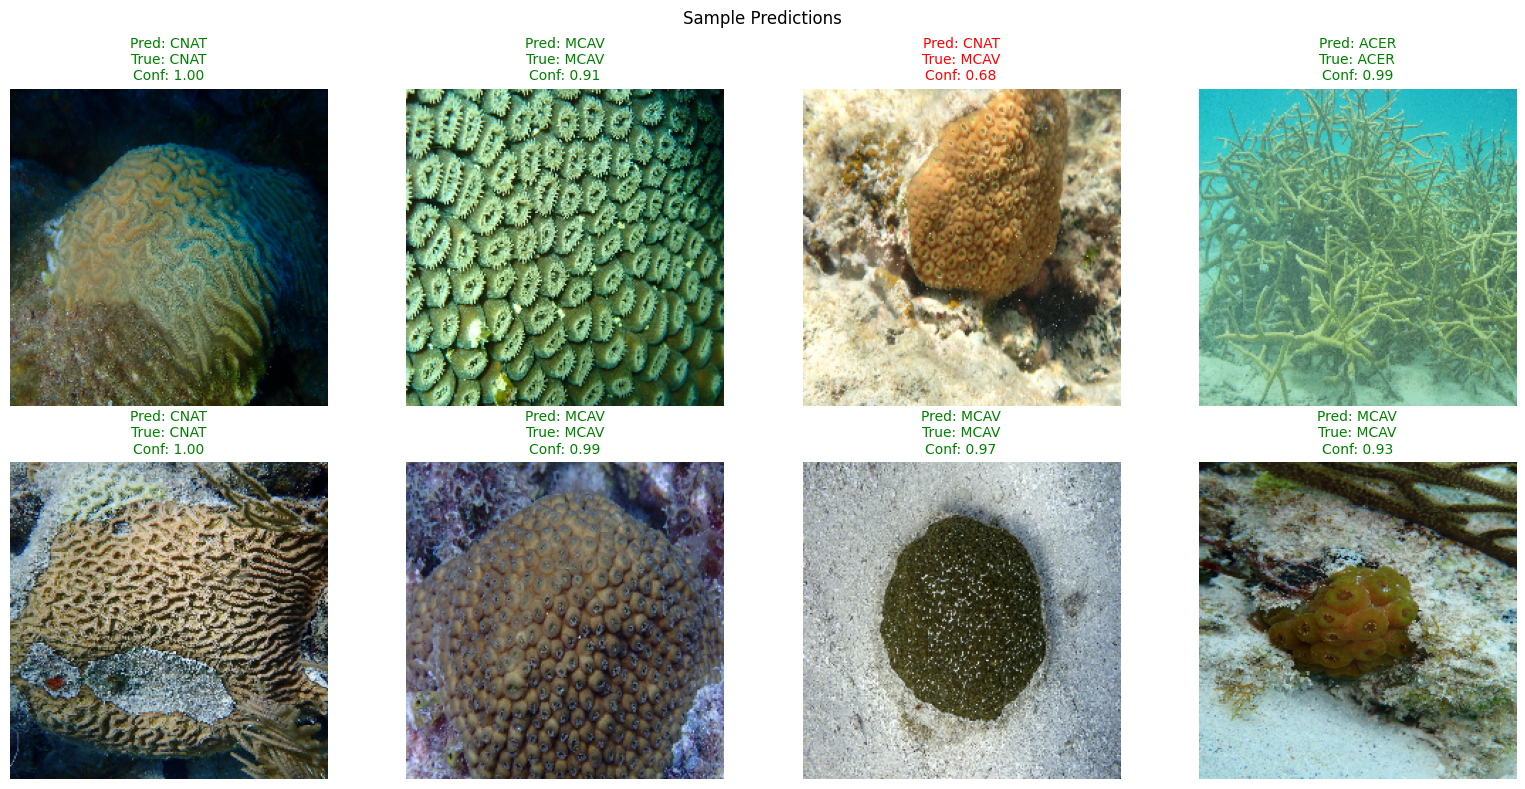

In [221]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Number of test images to show
num_images = 8

# Sample a few random rows from the test results
sample_df = vgg19_results_df.sample(n=num_images, random_state=123).reset_index(drop=True)

# Set up the plot grid
plt.figure(figsize=(16, 8))
for i in range(num_images):
    row = sample_df.iloc[i]
    img = load_img(row['Filepath'], target_size=(224, 224))
    
    plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    
    # Determine color based on prediction accuracy
    is_correct = row['Predicted Label'] == row['True Label']
    color = 'green' if is_correct else 'red'
    
    # Create title with colored text
    title = f"Pred: {row['Predicted Label']}\nTrue: {row['True Label']}\nConf: {row['Confidence']:.2f}"
    plt.title(title, fontsize=10, color=color)

plt.suptitle("Sample Predictions", fontsize=12)
plt.tight_layout()
plt.show()

# Final Thoughts and Wrap-Up

Congratulations! You've now built and evaluated two deep learning models for image classification:

1. **A CNN from scratch**  
   - Gave you hands-on experience building a model layer-by-layer
   - Showed the challenges of training with limited data (e.g. overfitting)

2. **A Transfer Learning model using VGG19**  
   - Leveraged features learned from millions of images (ImageNet)
   - Achieved higher accuracy and better generalization with fewer parameters and less training time

---

## Key Takeaways

- **Transfer learning is powerful** for small datasets — it helps you build accurate models with less data and compute.
- **ImageDataGenerator** is an essential tool for preprocessing, augmentation, and efficient image loading.
- **Callbacks** like `EarlyStopping` and `ReduceLROnPlateau` make training more stable and adaptive.
- **Evaluation tools** like confusion matrices and confidence-based prediction summaries are critical for interpreting model behavior.

---

## Possible Next Steps

If you're interested in improving this model further, here are some ideas to help push toward **perfect classification accuracy** on this dataset:

- **Fine-tune VGG19**: Unfreeze the deeper convolutional layers and retrain with a smaller learning rate.
- Try **different pre-trained architectures** like ResNet50, EfficientNet, or DenseNet for more expressive feature extraction.
- Explore **more aggressive data augmentation** strategies (color jitter, brightness shifts, cropping, noise).
- Apply **image cleaning or filtering** to reduce noise or poor-quality images from the dataset.
- Adjust **model architecture** and regularization: try different layer sizes, activations, or dropout configurations.
- Ensemble multiple models to combine strengths and reduce misclassifications.

---

### Contribute to This Tutorial!

If you manage to train a model that achieves **100% test accuracy** — or even just significantly outperforms the baseline — we’d love to see it!

You’re welcome to:
- Fork this repository
- Add your new model architecture, results, and notes
- Submit a **pull request** to contribute your improvements to this tutorial!

Let’s keep improving this together!

---

Thanks for following along! You’ve taken a big step toward understanding how deep learning can be applied to real-world biological image data like coral classification.